## EGM implementation

Task: Optimize consumption over retirement and find optimal investment in a fairly priced annuity; investment only possible at time = 0 (age 65)

### Symbols
$c_t$: Consumption
$w_t$: Wealth (beginning of period t)
$a_t := w_t-c_t$: End of period wealth
$p$: yearly payout of the annuity
$R := 1+r$ with $r$ being the interest rate
Wealth evolves according to $w_t = R * a_{t-1} + p$
$\sigma(w_t) = c_t^{*}$: Policy function


$u(c) := \frac{c^{1-\gamma}}{1-\gamma}$: Utility function (CRRA)
$\gamma$ is the risk aversion parameter

Value function V:

$$V(w) := max \sum_{t=s}^{T} (\prod_{y=s}^{t}S(y)) \beta^t u(c_t)$$
Where $S(y)$ is the probability of surviving age $y$, $s$ is the starting age and $T$ is the final period

Euler equation:
$$u'(c_t) = S(t) \beta R u'(c_{t+1})$$

Solved for c_t:
$$c_t = (u')^{-1} [S(t) \beta R u'(\sigma(a_t + p))]$$

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
from interpolation import interp
from numba import njit, float64, int64
from numba.experimental import jitclass

In [28]:
# This is a temporary workaround; I copied the survival probabilities from https://www.ssa.gov/oact/STATS/table4c6.html
@njit
def get_s_prob(s, T):
    l = np.array([0.993919, 0.999575, 0.99974, 0.999806, 0.999846, 0.999858, 0.999865, 0.999873, 0.999884, 0.999896, 0.999903, 0.999894, 0.999856, 0.99978, 0.999677, 0.999563, 0.999448, 0.999325, 0.999194, 0.999061, 0.998921, 0.998785, 0.998673, 0.998594, 0.998539, 0.998493, 0.998443, 0.99839, 0.998332, 0.998268, 0.998205, 0.998142, 0.998077, 0.998008,
 0.997936, 0.997855, 0.997769, 0.997684, 0.997602, 0.997518, 0.99742, 0.997303, 0.997172, 0.997024, 0.996854, 0.99666, 0.996433, 0.996167, 0.995857, 0.995501,
 0.99511, 0.994679, 0.99419, 0.993637, 0.993027, 0.992371, 0.991678, 0.990951, 0.990194, 0.989405, 0.988548, 0.987642, 0.986745, 0.985874, 0.984994, 0.983999,
 0.982876, 0.981702, 0.980481, 0.979153, 0.977619, 0.975815, 0.973734, 0.97134, 0.968599, 0.965382, 0.961737, 0.95781, 0.953633, 0.949052, 0.943763,
 0.93764, 0.930774, 0.923116, 0.914548, 0.904938, 0.894171, 0.882162, 0.868862, 0.854249, 0.838322, 0.821095, 0.802592, 0.782851, 0.7619199999999999, 0.741179,
 0.721034, 0.701908, 0.684238, 0.66845, 0.651872, 0.634466, 0.616189, 0.5969990000000001, 0.576849, 0.5556909999999999, 0.5334760000000001, 0.510149,
 0.485657, 0.45994, 0.432937, 0.404583, 0.37481299999999995, 0.343553, 0.310731, 0.27626799999999996,
 0.240081, 0.20208499999999996, 0.16218900000000003, 0.12029900000000004])
    return l[s:T]

@njit
def get_annuity_payment(annuity_investment, S, R):
    accumulated_p_surv = 1
    res = 0
    for t in range(len(S)):
        accumulated_p_surv *= S[t]
        res += accumulated_p_surv / R ** t
    return annuity_investment / res

In [154]:
jit_data = [
    ('w_0', float64),      # initial wealth
    ('beta', float64),     # discount factor
    ('gamma', float64),    # utility parameter
    ('s', int64),          # starting age
    ('T', int64),          # final period
    ('n', int64),          # number of simulated periods
    ('R', float64),        # 1 + interest rate
    ('S', float64[:]),     # Survival probabilities (array)
    ('p', float64),        # yearly annuity payment
    ('a_grid', float64[:]) # grid of end of period wealth
]

@jitclass(jit_data)
class Model:
    def __init__(self,
                 w_0=100,
                 beta=0.96,
                 gamma=5,
                 s=65,
                 T=100,
                 r=0.02,
                 annuity_investment=0,
                 grid_min=1e-10,
                 grid_max=100,
                 grid_size=200
                ):
        self.w_0, self.beta, self.gamma, self.s, self.T = w_0, beta, gamma, s, T
        self.n = T-s
        self.R = 1 + r
        self.S = get_s_prob(s, T)
        self.p = get_annuity_payment(annuity_investment, self.S, self.R)
        self.a_grid = np.linspace(grid_min, grid_max, grid_size)

    # Utility function
    def u(self, c):
        return c ** (1-self.gamma) / (1 - self.gamma)
    # Marginal utility
    def u_prime(self, c):
        if c==0:
            print("lel")
        return c ** -self.gamma
    # Inverse marginal utility
    def u_prime_inv(self, c):
        if c==0:
            print("lal")
        return c ** (-1 / self.gamma)

In [155]:
@njit
def K(sigma_array, model):
    # Initialize array for next iteration of sigma
    sigma_new = np.empty_like(sigma_array)

    # Also iterating over t since survival probability depends on it
    for t in range(model.n):
        # calculate w_grid and obtain policy function by interpolating
        w_grid = sigma_array[t] + model.a_grid
        w_grid[0] = 0
        sigma_array[t, 0] = 0
        sigma = lambda w: interp(w_grid, sigma_array[t], w)
        for i, a in enumerate(model.a_grid):
            temp = model.S[t] * model.beta * model.R * model.u_prime(sigma(a + model.p))
            sigma_new[t, i] = model.u_prime_inv(temp)

    return sigma_new

In [156]:
def solve_model(model, sigma, tol=1e-4, max_iter=1000, verbose=True, print_skip=25):
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        sigma_new = K(sigma, model)
        error = np.max(np.abs(sigma - sigma_new))
        sigma = sigma_new
        i += 1

        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.{maxindex}")

    if error > tol:
        print("Failed to converge!")
    elif verbose:
        print(f"\nConverged in {i} iterations.")

    return sigma_new

In [157]:
m = Model()
# Initial policy: c_t = a_{t-1}; np.tile creates an array with n rows that all contain a_grid
sigma_init = np.tile(m.a_grid, (m.n, 1))
sigma = solve_model(m, sigma_init)

Error at iteration 25 is 0.15386753134958386.0
Error at iteration 50 is 0.03889155045136983.0
Error at iteration 75 is 0.017151133541582375.0
Error at iteration 100 is 0.009487230292543503.0
Error at iteration 125 is 0.005929747814023889.0
Error at iteration 150 is 0.003996763081650201.0
Error at iteration 175 is 0.0028335778185055727.0
Error at iteration 200 is 0.0020819458034384564.0
Error at iteration 225 is 0.0015702565679326375.0
Error at iteration 250 is 0.0012079006075826904.0
Error at iteration 275 is 0.000943340475734189.0
Error at iteration 300 is 0.0007454829191188006.0
Error at iteration 325 is 0.0005946480237792873.0
Error at iteration 350 is 0.00047787435570301184.0
Error at iteration 375 is 0.0003863344231151977.0
Error at iteration 400 is 0.0003138420645620865.0
Error at iteration 425 is 0.0002559545720841605.0
Error at iteration 450 is 0.0002094132106386093.0
Error at iteration 475 is 0.00017178367456083254.0
Error at iteration 500 is 0.00014121862535854124.0
Error at 

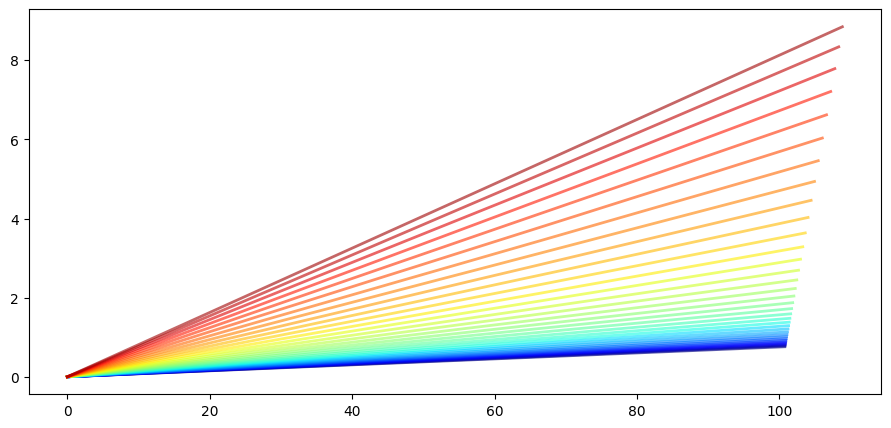

In [158]:
fig, ax = plt.subplots()

for i in range(len(sigma)):
    ax.plot(m.a_grid + sigma[i], sigma[i], color=plt.cm.jet(i / len(sigma)), lw=2, alpha=0.6)

(100,)

In [9]:
# For some testing
"""n = 100
m = Model()
sigma = np.tile(m.a_grid, (m.n, 1))
fig, ax = plt.subplots()

ax.plot(m.a_grid, sigma[34], color=plt.cm.jet(0), lw=2, alpha=0.6, label='Initial condition')

for i in range(n):
    sigma = K(sigma, m)
    ax.plot(m.a_grid, sigma[34], color=plt.cm.jet(i / n), lw=2, alpha=0.6)"""

(100,)